In [1]:
# importing Python modules
import os
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))
print("Python environment: {}".format(sys.executable))

import pandas as pd 
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook
print("pandas version: {}". format(pd.__version__))

import plotly_express as px
import matplotlib #collection of functions for scientific and publication-ready visualization
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 13
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
print("matplotlib version: {}". format(matplotlib.__version__))
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
print("seaborn version: {}". format(sns.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))
import scipy as sp #collection of functions for scientific computing and advance mathematics
from scipy import stats
from scipy.stats import norm, skew
print("SciPy version: {}". format(sp.__version__)) 
import statsmodels.api as sm
import itertools

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
from IPython.display import display
pd.options.display.max_columns = None
print("IPython version: {}". format(IPython.__version__)) 

import datetime
from datetime import datetime
from dateutil.parser import parse

# to make this notebook's output identical at every run
np.random.seed(42)

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

%load_ext autoreload
%autoreload 2
print("Imported required Python packages")

Python version: 3.6.8 |Anaconda custom (64-bit)| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Python environment: /Users/hamzabendemra/anaconda3/bin/python
pandas version: 0.24.2
matplotlib version: 2.1.2
seaborn version: 0.8.1
NumPy version: 1.16.3
SciPy version: 1.2.1
IPython version: 6.2.1


<IPython.core.display.Javascript object>

Imported required Python packages


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Get the Data

In [3]:
df = pd.read_excel("data/Superstore.xls")
print(df.shape)

(9994, 21)


In [4]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


## Furniture Sales

In [6]:
furniture = df.loc[df['Category'] == 'Furniture']
print(furniture.shape)

(2121, 21)


In [7]:
print("Furniture sales data time range: {} to {}".format(
    furniture['Order Date'].min(), furniture['Order Date'].max()))

Furniture sales data time range: 2014-01-06 00:00:00 to 2017-12-30 00:00:00


### Data Preprocessing

In [8]:
# keep necessary columns only
furniture = furniture[['Order Date', 'Sales']].copy()

In [9]:
# sort sales by date
furniture = furniture.sort_values('Order Date')

In [10]:
# check that there are no missing values
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [11]:
# quick glance at dataframe 
furniture.head(3)

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940


In [12]:
# group and sum sales by order date
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.head(5)

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [13]:
# set the order date as the index of the dataframe
furniture = furniture.set_index('Order Date')
furniture.head(5)

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [14]:
# resamplign dataframe into monthly averages with start of each month as the timestamp.
y = furniture['Sales'].resample('MS').mean()
y.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

### EDA

#### Sales data

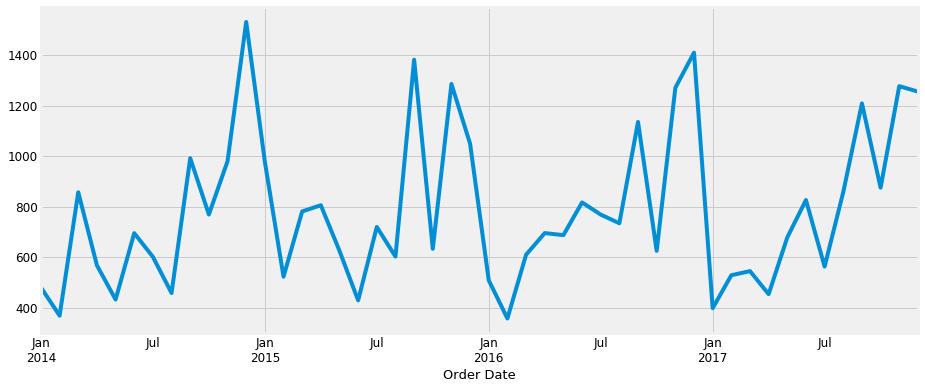

In [15]:
y.plot(figsize=(14, 6))
plt.show()

> Seasonality patterns are clear: sales are relatively low at the beginning of the year and high at the end of the year. <br>
> There is an overall upward trend within any single year with a couple of low months in the mid of the year.

#### Time-series decomposition

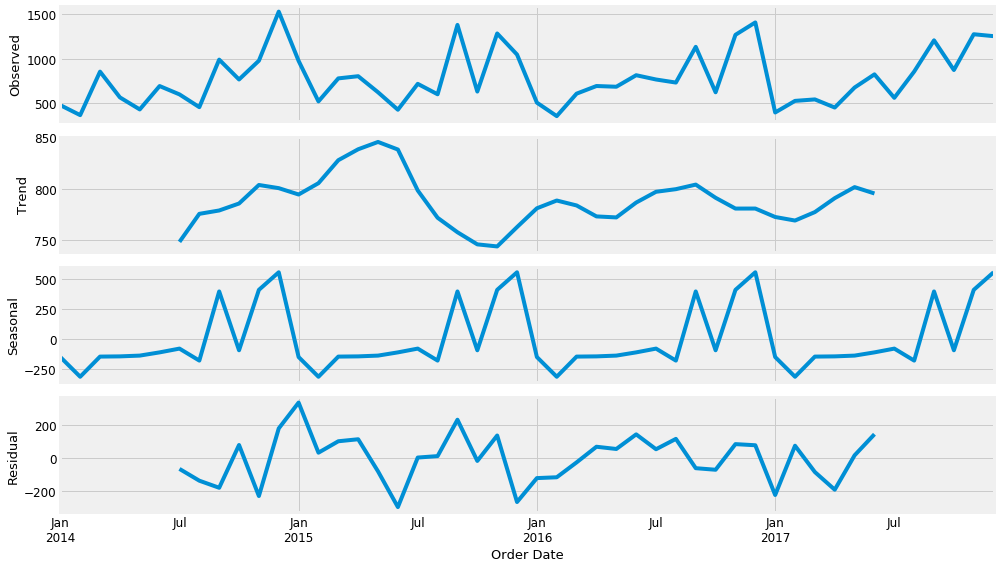

In [16]:
# Decompose time series into three distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
decomposition = sm.tsa.seasonal_decompose(y, 
                                          model='additive')
fig = decomposition.plot()
plt.show()

### Time series forecasting with ARIMA

> ARIMA : Autoregressive Integrated Moving Average. ARIMA models are denoted with the notation ARIMA(p, d, q). <br>
> These three parameters account for seasonality, trend, and noise in data.

In [17]:
# Examples of parameter combinations for Seasonal ARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
# Using “grid search” approach to find the optimal set of parameters 
# that yields the best performance for our model.
col = ['pdq', 'Seasonal pdq', 'AIC']
df_results = pd.DataFrame(columns=col)
i = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            df_results.loc[i] = [param, param_seasonal, round(results.aic, 2)]
            i += 1
        except:
            continue
df_results.sort_values(by=['AIC'], ascending=True).reset_index(drop=True).head(5)

,"Season p,d,q",RMSE SD,AIC
0,"(1, 1, 1)","(1, 1, 0, 12)",297.79
1,"(1, 1, 0)","(1, 1, 0, 12)",300.63
2,"(1, 0, 0)","(1, 1, 0, 12)",304.47
3,"(1, 0, 1)","(1, 1, 0, 12)",306.02
4,"(0, 1, 1)","(1, 1, 0, 12)",310.76


> The above output suggests that **SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.79**. Therefore we should consider this to be optimal option.

The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the **table of coefficients**. <br> The coef column shows the **weight (i.e. importance) of each feature** and how each one impacts the time series. <br> The **P>|z|** column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

In [19]:
## Fitting the ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


> When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. <br> The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

> Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.<br>

> In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:<br>
> - In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.<br>
> - The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.<br>
> - The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.<br>

> Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.


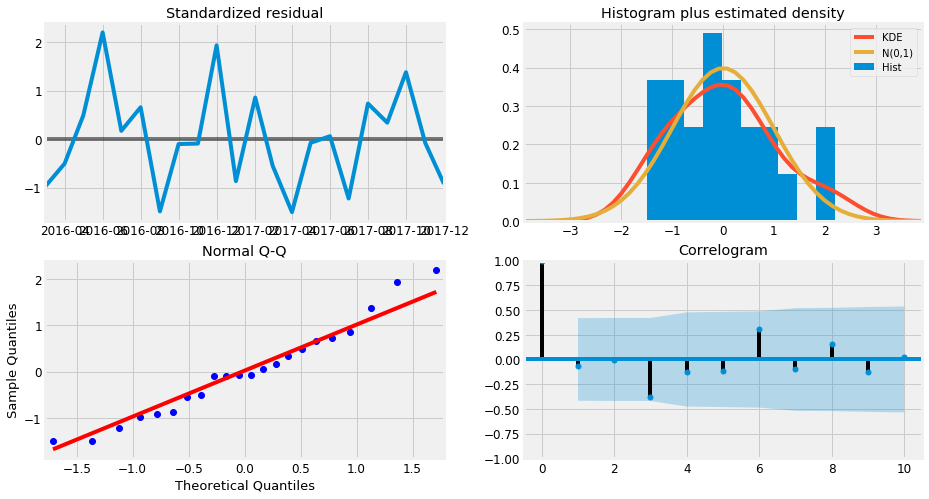

In [20]:
# Model diagnostics to investigate any unusual behavior
results.plot_diagnostics(figsize=(14, 8))
plt.show()

### Validating the forecast

In [ ]:
# get predictions
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),
                              dynamic=False)
# The dynamic=False argument ensures that we produce one-step ahead forecasts, 
# meaning that forecasts at each point are generated using the full history up to that point.

# get confidence intervals for forecasts of the time series
pred_ci = pred.conf_int()

# plot predictions with confidence intervals
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(
    ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower Sales,upper Sales
Order Date,,
2017-01-01,204.676401,895.518227
2017-02-01,31.859480,721.912714
2017-03-01,296.216052,985.551813
2017-04-01,373.137945,1061.818148
2017-05-01,347.351126,1035.430000


In [23]:
pred.predicted_mean

Order Date
2017-01-01     550.097314
2017-02-01     376.886097
2017-03-01     640.883932
2017-04-01     717.478047
2017-05-01     691.390563
2017-06-01     815.731660
2017-07-01     776.952347
2017-08-01     729.182217
2017-09-01    1149.878782
2017-10-01     633.943128
2017-11-01    1291.341559
2017-12-01    1417.169156
Freq: MS, dtype: float64

> It is also useful to quantify the accuracy of our forecasts. We will use the **MSE (Mean Squared Error)**, which summarizes the average error of our forecasts. <br>
> For each predicted value, we compute its **distance to the true value and square the result**. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean. <br>
> An **MSE of 0** would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

In [24]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 22993.58


Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set **within 151.64 of the real sales**. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

### Producing and visualizing forecasts

The **get_forecast()** attribute of our time series object can compute forecasted values for a specified number of **steps** ahead.

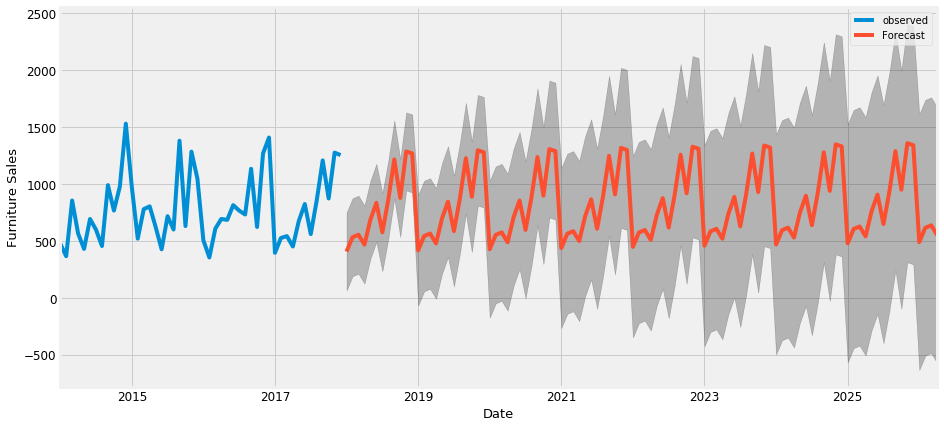

In [26]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Time Series of Furniture vs. Office Supplies

In [27]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

### Data Processing

In [28]:
## remove unecessary columns
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
        'Customer Name', 'Segment', 'Country', 'City', 'State',
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
## sort sales data by Order Dates
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
## group and sum sales data by order data
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
# set OrderDate as the df's index
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
# resample the sales data by month, first day of the month as the timestamp
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
# create dataframes with sales data
furniture = pd.DataFrame(
    {'Order Date': y_furniture.index, 'Sales': y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
# merge both dataframes into a one dataframe
store = furniture.merge(office, how='inner', on='Order Date')
# rename the columns
store.rename(columns={'Sales_x': 'furniture_sales',
                      'Sales_y': 'office_sales'}, inplace=True)
# show first rows of combined sales data dataframe
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


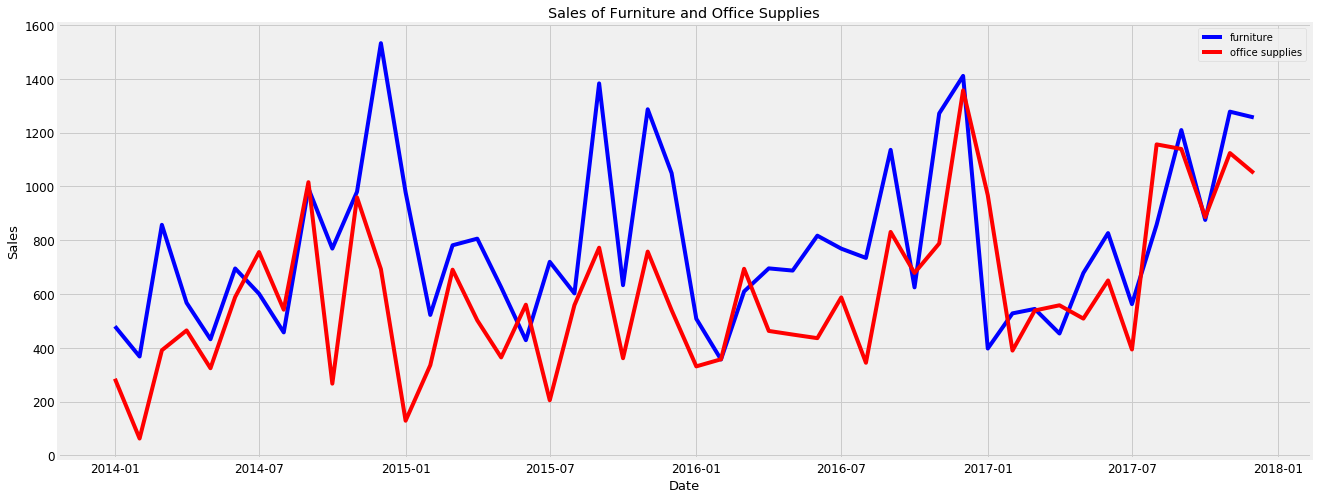

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); 
plt.ylabel('Sales'); 
plt.title('Sales of Furniture and Office Supplies')
plt.legend();

Occasionally, office supplies passed furniture on average daily sales. Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s.

In [30]:
first_date = store.ix[np.min(list(
    np.where(store['office_sales'] > store['furniture_sales'])[0])),
    'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(
    first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


## Time Series Modeling with Prophet

Forecasting tool **Prophet** is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. <br>
It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. 

Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [31]:
from fbprophet import Prophet

### Furniture Sales Forecast

In [ ]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

In [32]:
# fitting Prophet to furniture sales data
furniture_model = Prophet(interval_width=0.95,
                          daily_seasonality=False,
                          weekly_seasonality=False)
furniture_model.fit(furniture)

In [33]:
# create Prophet sales forecast for furniture
furniture_forecast = furniture_model.make_future_dataframe(
    periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

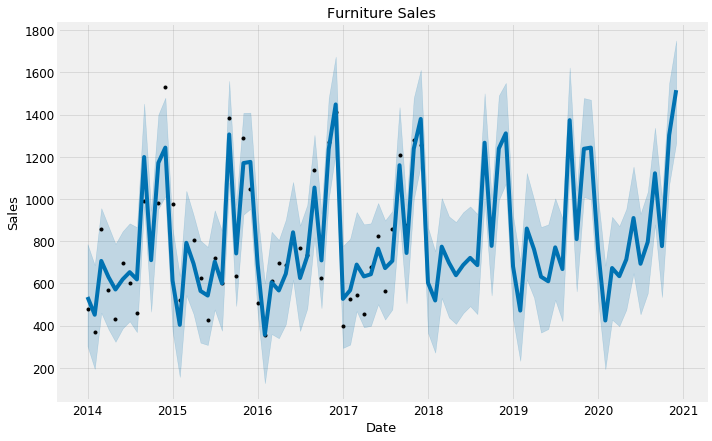

In [34]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel='Date', ylabel='Sales')
plt.title('Furniture Sales');

### Office Supplies Sales Forecast

In [35]:
# fitting Prophet to office supplies sales data
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95,
                       daily_seasonality=False,
                       weekly_seasonality=False)
office_model.fit(office)

In [36]:
# create Prophet sales forecast for office supplies
office_forecast = office_model.make_future_dataframe(
    periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

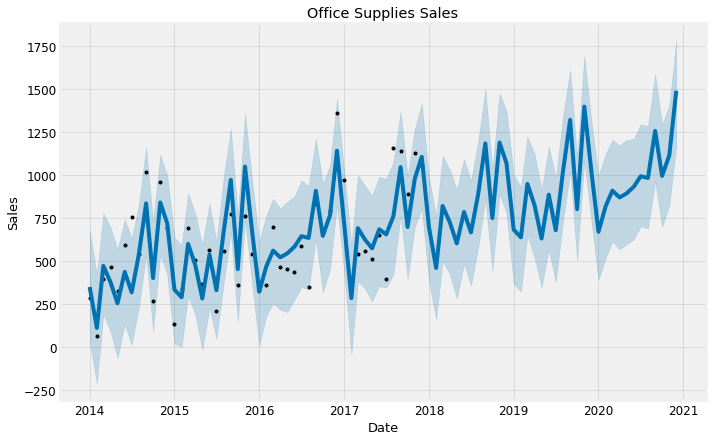

In [37]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

## Compare ARIMA and Prophet Forecasts

> We already have the forecasts for three years for these two categories into the future. <br> We will now join them together to compare their future forecasts.

### Data Processing

In [51]:
# get column names of Prophet forecast output dataframes
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

In [55]:
# copy Prophet sales forecast data
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
# assigning new columns names to forecast dataframes
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

In [56]:
# merge dataframes
forecast = pd.merge(merge_furniture_forecast, 
                    merge_office_forecast, 
                    how = 'inner', 
                    left_on = 'furniture_ds', 
                    right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat,office_trend,office_yhat_lower,office_yhat_upper,office_trend_lower,office_trend_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,302.424230,785.922213,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,0.0,0.0,0.0,535.372051,487.530759,29.597815,674.327174,487.530759,487.530759,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,194.757863,686.208964,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,0.0,0.0,0.0,451.116320,494.918445,-212.007398,419.154087,494.918445,494.918445,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,460.797279,956.283774,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,0.0,0.0,0.0,706.401580,501.591193,192.795206,775.171242,501.591193,501.591193,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,382.783176,870.405592,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,0.0,0.0,0.0,630.086487,508.978878,87.871176,693.901209,508.978878,508.978878,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,323.060918,786.754073,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,0.0,0.0,0.0,570.801960,516.128251,-66.197672,566.336297,516.128251,516.128251,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


### Trend and Forecast Visualization

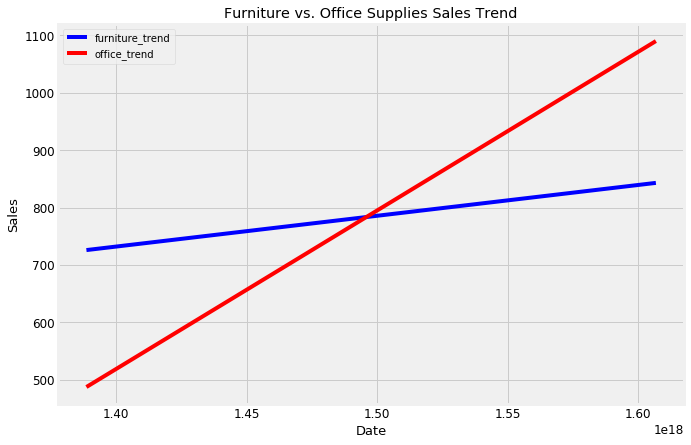

In [57]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); 
plt.xlabel('Date'); 
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

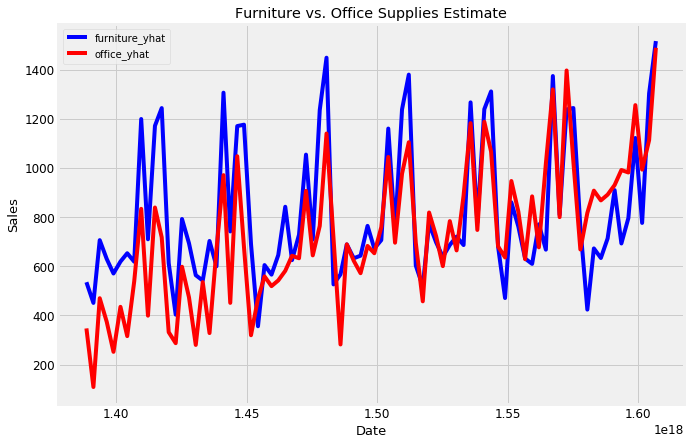

In [58]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); 
plt.xlabel('Date'); 
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

### Trends and Patterns

> Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

#### Furniture Sales Components

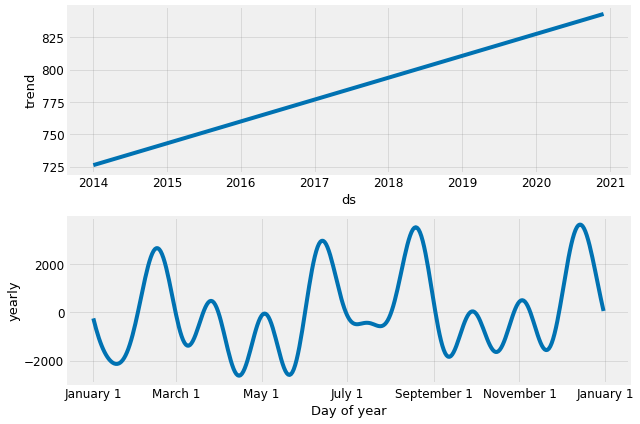

In [59]:
furniture_model.plot_components(furniture_forecast);

#### Furniture Office Supplies Components

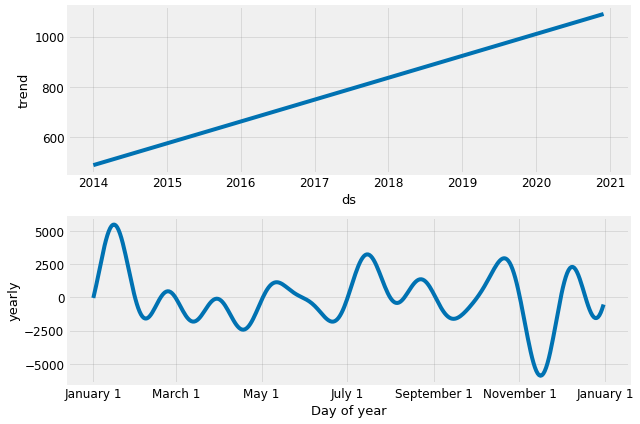

In [60]:
office_model.plot_components(office_forecast);